In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import os
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam


from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



## Introduction

The kaggle competition is a classic computer vision problem for binary classification. My goal is to create an algorithm to identify metastatic cancer from the image.  

## Data

The data for this competition is a modify version of PatchCamelyon benchmark dataset and was provided by Bas Veeling, with additional input from Babak Ehteshami Bejnordi, Geert Litjens, and Jeroen van der Laak. 

Kaggle has split the data into 2 image folders and 2 csv files. Train folder contains 20,025 images and the test folder contains 57,468 images. Each image is 96px by 96px. The csv files contains the image file id and whether the image is cancerous. 

In [29]:
test_path = '/kaggle/input/histopathologic-cancer-detection/test/'
train_path = '/kaggle/input/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
train_data = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

print(train_data.shape)


(220025, 2)


In [30]:
print(train_data.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [31]:
print(train_data['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64


(array([130908.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  89117.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

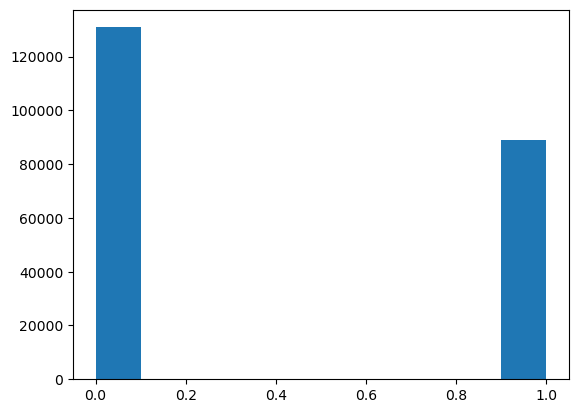

In [32]:
plt.hist(train_data['label'])

## Exploratory Data Analysis 

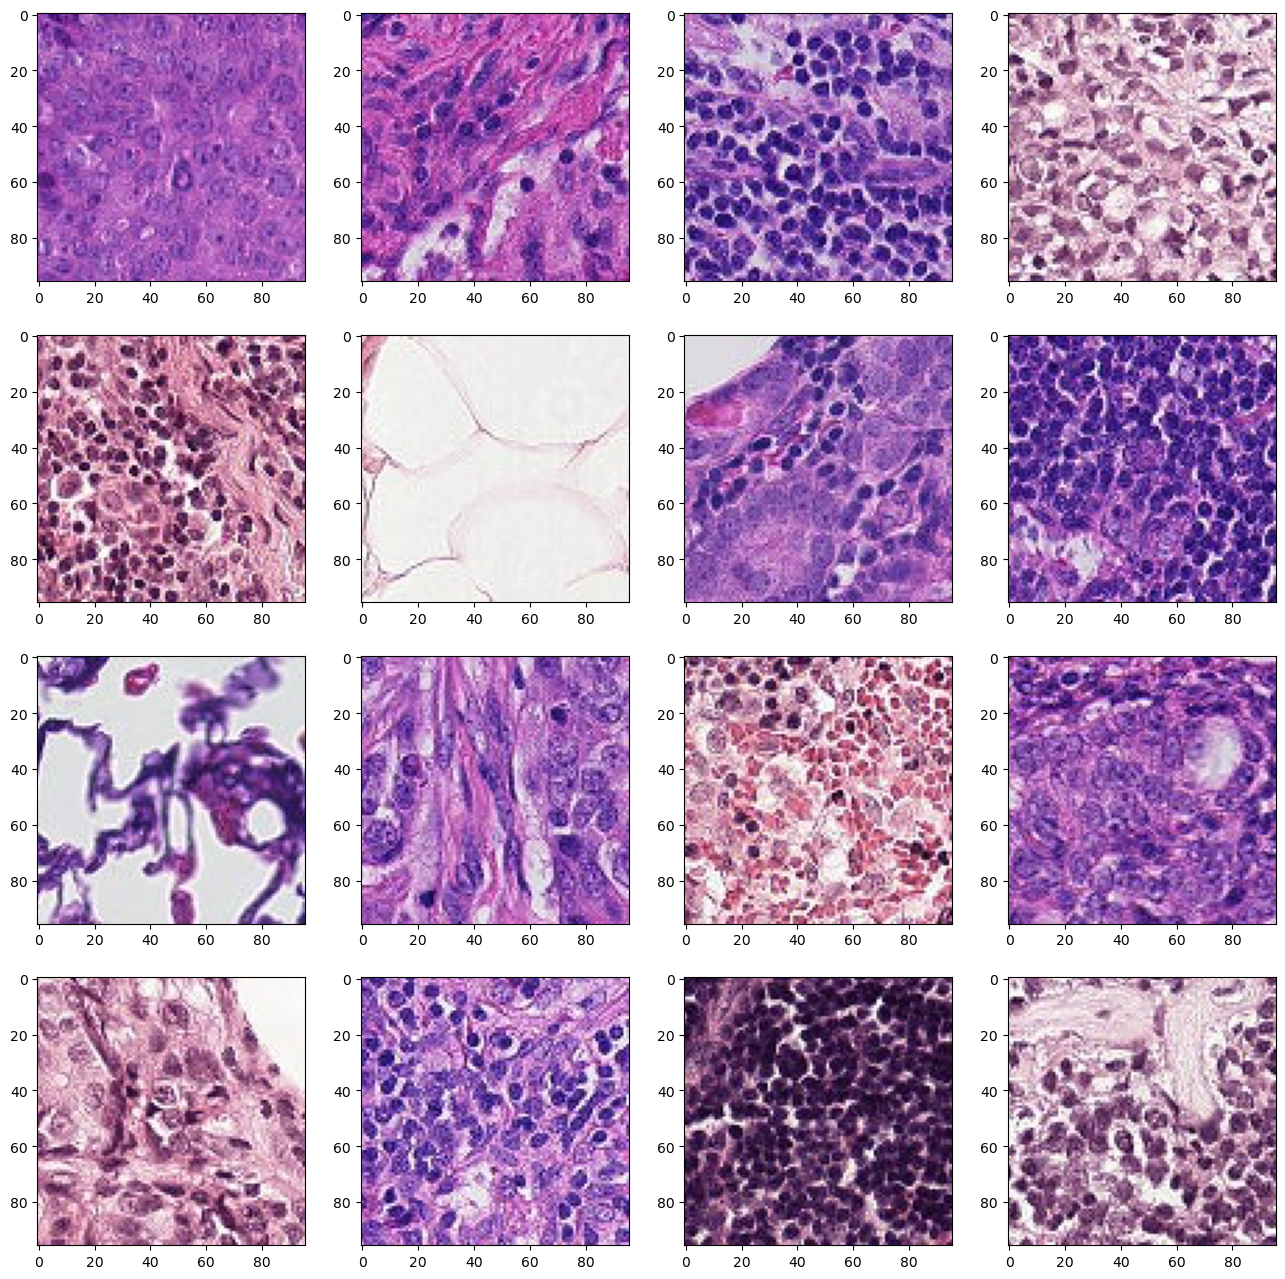

In [33]:
plt.figure(1, figsize=(16, 16))
for i in range(16):
    random_img = random.choice(train_data.id)
    img = train_path+random_img+'.tif'
    imgs = plt.imread(img)
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs)

In [34]:
image = Image.open(img)
#PIL images into NumPy arrays
numpydata = np.asarray(image)
 
# <class 'numpy.ndarray'>
print(type(numpydata))
 
#  shape
print(numpydata.shape)

<class 'numpy.ndarray'>
(96, 96, 3)


## Data Preprocessing and Plan of Analysis 

We will normalize the pixels using ImageDataGenerator. Also the data is too big so we will choose the 10000

In [35]:
train_data["name"] = train_data["id"].apply(lambda x: str(x+".tif"))
train_data["categorical"] = train_data["label"].apply(lambda x: str(x))


train_data = train_data[train_data["label"] == '1'].sample(n = 1000)
print(train_data.head())
print(train_data.shape)

                                              id  label  \
131973  d248b215b8151e2f36e928e4bc28a3cdda49fb43      0   
50259   f0d0ca8941bdd0734e40cbbf31a506e1b2d95028      0   
216627  d6d34f783d60beff0d926ec9647e8e466f565b67      0   
157829  590e1b65866e66face9e5560af05c6142339caef      0   
187132  608ddf0463e7c9cd91ece84e3043401dda8f7872      1   

                                                name categorical  
131973  d248b215b8151e2f36e928e4bc28a3cdda49fb43.tif           0  
50259   f0d0ca8941bdd0734e40cbbf31a506e1b2d95028.tif           0  
216627  d6d34f783d60beff0d926ec9647e8e466f565b67.tif           0  
157829  590e1b65866e66face9e5560af05c6142339caef.tif           0  
187132  608ddf0463e7c9cd91ece84e3043401dda8f7872.tif           1  
(2000, 4)


(array([1200.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         800.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

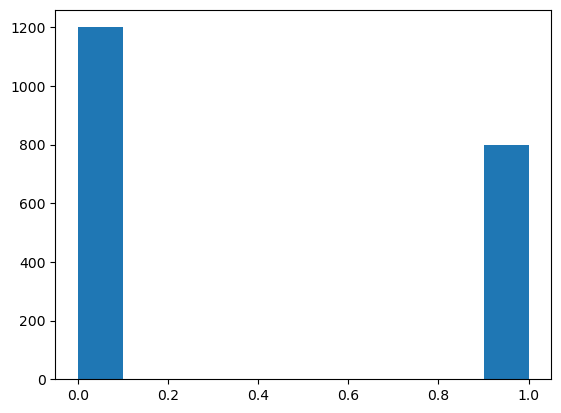

In [36]:
plt.hist(train_data['label'])

In [37]:
datagen = ImageDataGenerator(rescale = 1.0/255, validation_split = 0.20)

train_generator = datagen.flow_from_dataframe(train_data,
                                          directory = train_path,
                                          x_col = 'name',
                                          y_col = 'categorical',
                                          subset = 'training',
                                          class_mode = 'binary',
                                          seed = 42,
                                          target_size = (96, 96))

test_generator = datagen.flow_from_dataframe(dataframe=train_data,
                                             directory=train_path,
                                             x_col="name",
                                             y_col="categorical",
                                             subset="validation",
                                             batch_size=256,
                                             class_mode="binary",
                                             target_size=(96,96))  

Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


## Model Architecture

### 1st Model
The first model will be very shallow, it only have 2 convolution layer.

In [38]:
model1 = tf.keras.models.Sequential()

model1.add(layers.Conv2D(32,  (3,3), activation='relu', input_shape=(96,96,3)))
model1.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"))
model1.add(layers.Conv2D(64, (3,3), activation='relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(1024))
model1.add(layers.Dense(1, activation='sigmoid'))# last layer should be the size of the output
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 129600)            0         
                                                                 
 dense (Dense)               (None, 1024)              132711424 
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                        

In [39]:
model1.compile(optimizer=Adam(lr=0.0001), 
               loss='binary_crossentropy', 
               metrics=['accuracy'])

In [40]:
model1_history = model1.fit(train_generator,
                            epochs = 10,
                            validation_data = test_generator)

Epoch 1/10
50/50 [==============================] - 119s 2s/step - loss: 4.0698 - accuracy: 0.6481 - val_loss: 0.6452 - val_accuracy: 0.6575
Epoch 2/10
50/50 [==============================] - 114s 2s/step - loss: 0.5126 - accuracy: 0.7588 - val_loss: 0.5836 - val_accuracy: 0.6925
Epoch 3/10
50/50 [==============================] - 113s 2s/step - loss: 0.4715 - accuracy: 0.7956 - val_loss: 0.5588 - val_accuracy: 0.7575
Epoch 4/10
50/50 [==============================] - 112s 2s/step - loss: 0.3759 - accuracy: 0.8413 - val_loss: 0.6014 - val_accuracy: 0.6975
Epoch 5/10
50/50 [==============================] - 112s 2s/step - loss: 0.2601 - accuracy: 0.9094 - val_loss: 0.6837 - val_accuracy: 0.7675
Epoch 6/10
50/50 [==============================] - 112s 2s/step - loss: 0.1803 - accuracy: 0.9369 - val_loss: 0.7592 - val_accuracy: 0.7375
Epoch 7/10
50/50 [==============================] - 118s 2s/step - loss: 0.1292 - accuracy: 0.9600 - val_loss: 0.8647 - val_accuracy: 0.6925
Epoch 8/10
50

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


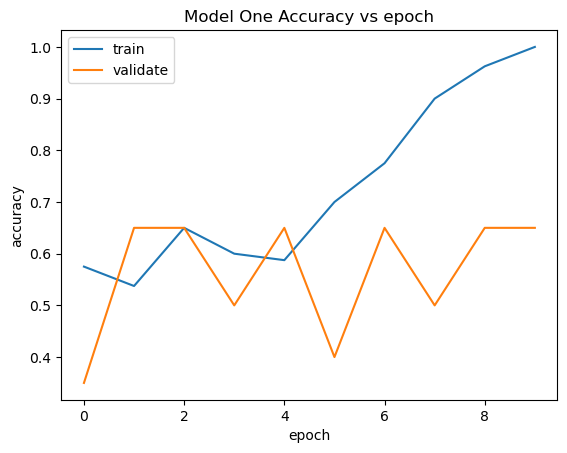

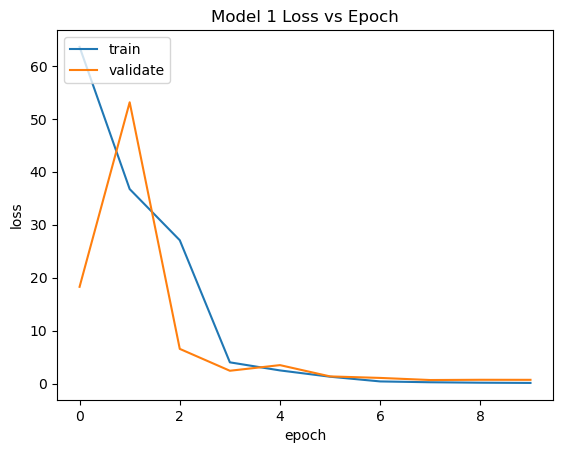

In [80]:
print(model1_history.history.keys())

# plot model accuracy per epoch 
plt.plot(model1_history.history['accuracy'])
plt.plot(model1_history.history['val_accuracy'])
plt.title('Model One Accuracy vs epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(model1_history.history['loss'])
plt.plot(model1_history.history['val_loss'])
plt.title('Model 1 Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

In [81]:
y1_pred = model1.predict(test_generator, verbose = 1)
y1_pred = list(map(lambda x: 0 if x < 0.5 else 1, y1_pred))
print(classification_report(test_generator.classes, y1_pred))

1/1 [==============================] - 0s 264ms/step
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        13
           1       0.00      0.00      0.00         7

    accuracy                           0.65        20
   macro avg       0.33      0.50      0.39        20
weighted avg       0.42      0.65      0.51        20



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2nd Model

This is a much more complex model, it is much deeper with drop out layer in between. 

In [82]:
model2 = Sequential()

model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',input_shape=(96,96,3)))
model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"))
model2.add(Dropout(0.1))

model2.add(BatchNormalization())
model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.1))

model2.add(BatchNormalization())
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(BatchNormalization())
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model2.add(Flatten())
model2.add(Dense(1024))
model2.add(Dense(1, activation='sigmoid'))


# Summary of the 2nd model
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_33 (Conv2D)          (None, 92, 92, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 46, 46, 64)        0         
                                                                 
 batch_normalization_12 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_34 (Conv2D)          (None, 44, 44, 128)      

In [83]:
model2.compile(optimizer=Adam(lr=0.0001), 
               loss='binary_crossentropy', 
               metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
model2_history = model2.fit(train_generator,
                            epochs = 10,
                            validation_data = test_generator)

Epoch 1/10


In [ ]:
print(model2_history.history.keys())

# plot model accuracy per epoch 
plt.plot(model2_history.history['accuracy'])
plt.plot(model2_history.history['val_accuracy'])
plt.title('Model One Accuracy vs epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(model2_history.history['loss'])
plt.plot(model2_history.history['val_loss'])
plt.title('Model 1 Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

In [ ]:
y2_pred = model2.predict(test_generator, verbose = 1)
y2_pred = list(map(lambda x: 0 if x < 0.5 else 1, y2_pred))
print(classification_report(test_generator.classes, y2_pred))

## Results and Analysis 

I think the second model worked better because it is much deeper than the first one. A deeper neural network, a more complex function can be learn. This enabled the networks to discrimate between different classes easier.

## Conclusion 

From the models above, a deeper network is better than a shallow network. Also the size of kernel/filter affect the number of parameters. From what I learned in classes, it seems in practice, peopel tends to use smaller filter and deeper network because its has the same number of parameter as a network that has a bigger filter and shallower networkteration of results. It is also more accurate. Techniques like resizing, flipping, rotating, cropping, padding, can help improve the model, and make the model robust perform better.


## Submission for Ranking

In [ ]:
sample_submission["name"] = sample_submission["id"].apply(lambda x: str(x+".tif"))
sample_submission["categorical"] = sample_submission["label"].apply(lambda x: str(x))

#sample_submission = sample_submission[0:100]

In [ ]:
subgen = ImageDataGenerator(rescale = 1.0/255)
submission_generator = subgen.flow_from_dataframe(sample_submission,
                                          directory = test_path,
                                          x_col = 'name',
                                          y_col = 'categorical',
                                          target_size = (96, 96))

In [ ]:
pred = model2.predict(submission_generator, verbose = 1)

In [ ]:
lab = pd.DataFrame()
lab['id'] = sample_submission['id'].apply(lambda x: str(x))
lab['label'] = list(map(lambda x: 0 if x < 0.5 else 1, pred))
lab.head()

In [ ]:
lab.to_csv('submission.csv', index = False)